# From cosmology to linear power parameters
We would like to see if we can compress the linear power spectrum information in a handful of parameters.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.dpi'] = 150
import camb
from camb import model, initialpower
import fit_pk
import read_genic

### Specify cosmological models

In [2]:
# read cosmology from GenIC file
cosmo_genic = 'param_keir.genic'
#cosmo_genic = 'param_chris.genic'
cosmo_dict = read_genic.camb_from_genic(cosmo_genic)
#print(cosmo_dict)
pars = fit_pk.get_cosmology(cosmo_dict)

In [3]:
# setup fiducial cosmology
pars_fid = fit_pk.get_cosmology(mnu=0.3)

### Run CAMB to get power spectra

In [4]:
## output redshifts
zs=[2,2.9,3,3.1,5]
Nz=len(zs)
# central point will be z_star=3
iz_star=2
z_star=zs[iz_star]
if Nz is not 5:
    raise ValueError("The rest of the notebook expects you use five redshifts")
if not (z_star == 3.0):
    raise ValueError("The rest of the notebook expects the central redshift to be z_star =3")

In [5]:
k_Mpc, zs_out, P_Mpc = fit_pk.get_Plin_Mpc(pars,zs)

Note: redshifts have been re-sorted (earliest first)


In [6]:
k_Mpc_fid, _, P_Mpc_fid = fit_pk.get_Plin_Mpc(pars_fid,zs=zs)

Note: redshifts have been re-sorted (earliest first)


### Compute ratio of power at $z_\star=3$ and fit a polynomial to log ratio

In [7]:
k_ratio=np.logspace(-4,1,1000)
P_ratio=np.interp(k_ratio,k_Mpc,P_Mpc[iz_star]) / np.interp(k_ratio,k_Mpc_fid,P_Mpc_fid[iz_star])
# use a certain k range to fit
k_fit_min=0.1
k_fit_max=5.0
# try two different polynomials
P_ratio_deg1=fit_pk.fit_polynomial(k_fit_min,k_fit_max,k_ratio,P_ratio,deg=1)
P_ratio_deg2=fit_pk.fit_polynomial(k_fit_min,k_fit_max,k_ratio,P_ratio,deg=2)

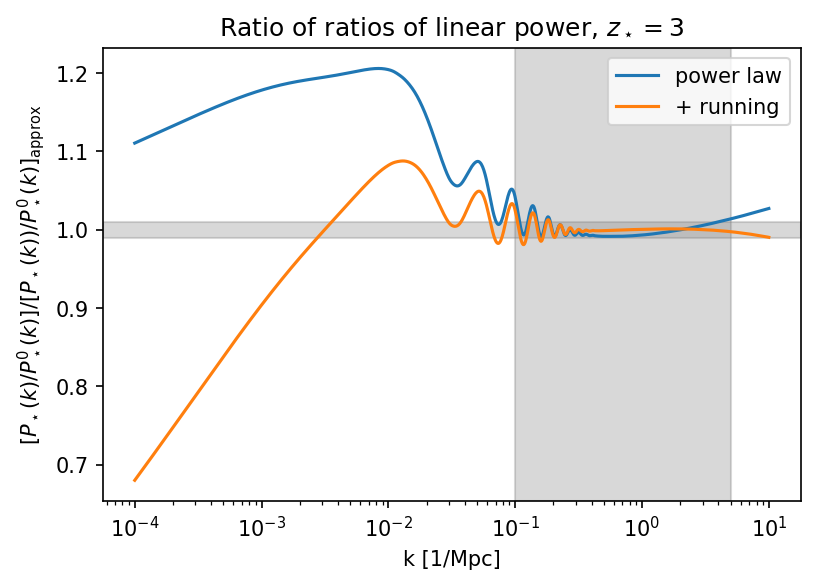

In [8]:
plt.figure()
plt.semilogx(k_ratio,P_ratio/np.exp(P_ratio_deg1(np.log(k_ratio))),label='power law')
plt.semilogx(k_ratio,P_ratio/np.exp(P_ratio_deg2(np.log(k_ratio))),label='+ running')
plt.title(r"Ratio of ratios of linear power, $z_\star=$"+str(z_star))
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"[$P_\star(k)/P_\star^0(k)] / [P_\star(k))/P_\star^0(k)]_{\rm approx}$")
plt.legend()
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

### Compute the linear growth and the logarithmic growth rate

Let us compute the linear growth, with respect Einstein-de Sitter
$$ \eta(z,k) = \frac{D(z)}{D_\star} \frac{a_\star}{a(z)} = \sqrt{\frac{P(z,k)}{P_\star(k)}} \frac{a_\star}{a(z)} $$
where quantities with $_\star$ have been evaluated at $z_\star=3$.

In [9]:
eta = np.ones_like(P_Mpc)
eta_fid = np.ones_like(P_Mpc_fid)
for iz in range(Nz):
    eta[iz]=np.sqrt(P_Mpc[iz]/P_Mpc[iz_star])*(1+zs_out[iz])/(1+z_star)
    eta_fid[iz]=np.sqrt(P_Mpc_fid[iz]/P_Mpc_fid[iz_star])*(1+zs_out[iz])/(1+z_star)

Let us compute now the logarithmic growth rate at $z_\star=3$, and around $k_p=1 Mpc^{-1}$.
$$ f_\star(k) = 1 - (1+z_\star)\frac{\partial \eta(z,k)}{\partial z} \Bigr\rvert_{z_\star}$$

In [10]:
k_p_Mpc=1.0
f_star=fit_pk.fit_f_star(zs_out[iz_star-1:iz_star+2],P_Mpc[iz_star-1:iz_star+2],k_Mpc,k_p_Mpc)
f_star_fid=fit_pk.fit_f_star(zs_out[iz_star-1:iz_star+2],P_Mpc_fid[iz_star-1:iz_star+2],k_Mpc_fid,k_p_Mpc)

### Reconstruct the linear power using the shape parameters and the logarithmic growth rate

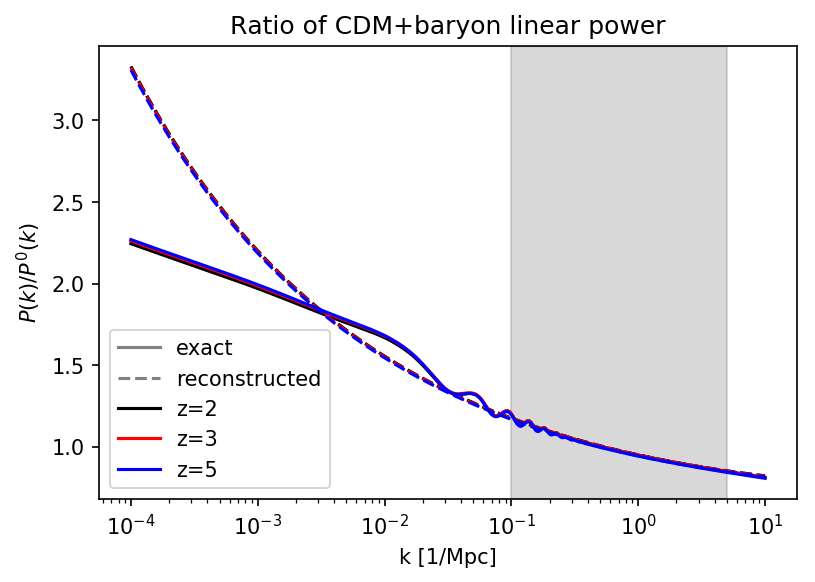

In [11]:
plt.figure()
colors=['black','red','red','red','blue']
for iz in [0,2,4]: 
    z=zs[iz]
    col=colors[iz]
    # interpolate both powers to same k grid
    P=np.interp(k_ratio,k_Mpc,P_Mpc[iz])
    P_fid=np.interp(k_ratio,k_Mpc_fid,P_Mpc_fid[iz])
    # compute true ratio at this z
    P_ratio_true=P / P_fid
    # reconstruct power, starting by correcting the shape at z_star=3
    P_shape = P_fid * np.exp(P_ratio_deg2(np.log(k_ratio)))
    # correct linear growth
    P_rec = P_shape * (1+(f_star_fid-f_star)*(z-z_star)/(1+z_star))**2
    if iz==0:
        plt.semilogx(k_ratio,P/P_fid,'-',color='gray',label='exact')
        plt.semilogx(k_ratio,P_rec/P_fid,'--',color='gray',label='reconstructed')    
    plt.semilogx(k_ratio,P/P_fid,'-',color=col,label='z='+str(z))
    plt.semilogx(k_ratio,P_rec/P_fid,'--',color=col)    
plt.title(r"Ratio of CDM+baryon linear power")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k) / P^0(k)$")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

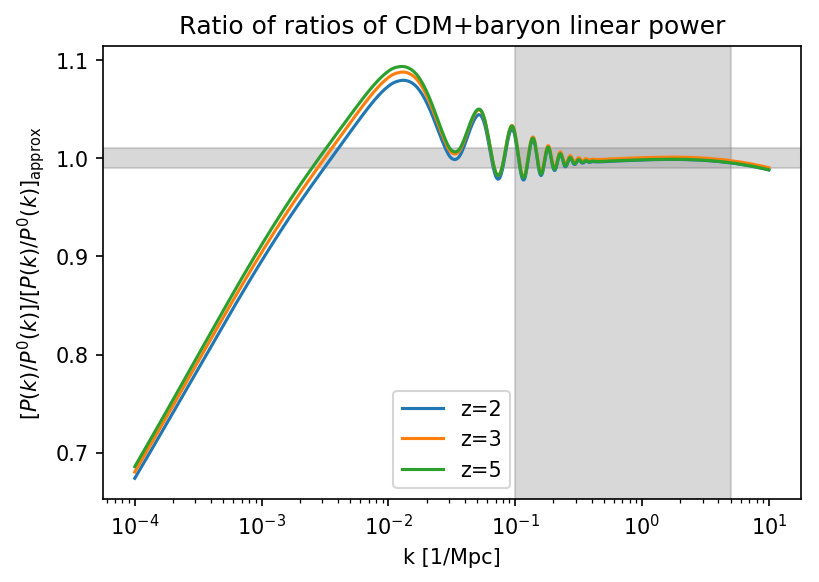

In [12]:
plt.figure()
for iz in [0,2,4]: 
    z=zs[iz]
    # interpolate both powers to same k grid
    P=np.interp(k_ratio,k_Mpc,P_Mpc[iz])
    P_fid=np.interp(k_ratio,k_Mpc_fid,P_Mpc_fid[iz])
    # compute true ratio at this z
    P_ratio_true=P / P_fid
    # reconstruct power, starting by correcting the shape at z_star=3
    P_shape = P_fid * np.exp(P_ratio_deg2(np.log(k_ratio)))
    # correct linear growth
    P_rec = P_shape * (1+(f_star_fid-f_star)*(z-z_star)/(1+z_star))**2
    plt.semilogx(k_ratio,P/P_rec,label='z='+str(z))
plt.title(r"Ratio of ratios of CDM+baryon linear power")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$[P(k) / P^0(k)] / [P(k) / P^0(k)]_{\rm approx}$")
plt.legend()
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')